In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os
import datetime
import numpy as np
import torch
import torch.nn.functional as F

torch.autograd.set_detect_anomaly(True)
# torch.set_default_dtype(torch.float32)

import mediapy as mpy
from tqdm.auto import tqdm
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import wandb

from nca_model import NCAModel, SimpleNCA
from pool import NCAPool
from utils import nca_out_to_vids, tonp, save_model, load_latest_model, nca_cmap
from data import MNISTPatternGenerator, MNISTPatternPool, generate_radial_circles_pattern

In [22]:
os.environ["WANDB_NOTEBOOK_NAME"] = "./train.ipynb"

In [23]:
device = "cuda"
num_classes = 10
channs = 16
bs = 16
S = 80
lr = 0.0008
pool_size = 64
pool_replacement = 0.8

In [24]:
# nca = NCAModel(channel_n=channs, device=device)
nca = SimpleNCA(channs).to(device)

In [25]:
inp = torch.rand(5, channs, S, S).to(device)
out = nca(inp, steps=50)
len(out), out[0].shape

(51, torch.Size([5, 16, 80, 80]))

,,,,

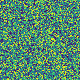
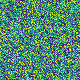
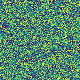
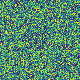
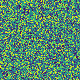

In [26]:
nca_out_to_vids(out)

In [27]:
pattern = generate_radial_circles_pattern(S, num_classes)
gen = MNISTPatternGenerator(
    is_train=True, channs=channs, bs=bs, pattern=pattern
)

In [28]:
pool = MNISTPatternPool(
    is_train=True, channs=channs, size=S, pool_size=pool_size, pattern=pattern
)

In [29]:
sample = pool.sample(bs=bs)

""

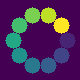

In [30]:
mpy.show_image(gen.pattern, cmap="viridis", width=150)

In [31]:
batch = next(gen)

,,,,,,,

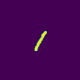
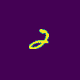
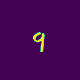
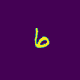
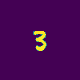
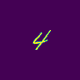
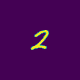
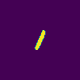

In [32]:
mpy.show_images(batch["inp"][:8,0], cmap="viridis", width=100, columns=8)

,,,,,,,

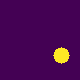
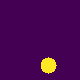
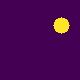
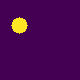
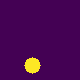
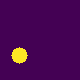
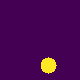
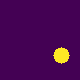

In [33]:
mpy.show_images(batch["out"][:8], cmap="viridis", width=100, columns=8)

In [34]:
# nca = NCAModel(channel_n=channs, device=device)
nca = SimpleNCA(channs).to(device)

In [35]:
import torch.nn as nn

clf = nn.Sequential(
    nn.Linear(6400, 10),
).to(device)

In [17]:
pattern = generate_radial_circles_pattern(S, num_classes)
# train_gen = MNISTPatternGenerator(
#     is_train=True, channs=channs, bs=bs, pattern=pattern
# )
train_gen = MNISTPatternPool(
    is_train=True, channs=channs, pattern=pattern, pool_size=pool_size, size=S,
    replacement=pool_replacement,
)
test_gen = MNISTPatternGenerator(
    is_train=False, channs=channs, bs=8, pattern=pattern
)

optim = torch.optim.Adam([*nca.parameters(), *clf.parameters()], lr=lr)
history = []

In [18]:
run = wandb.init(
    project="nca-classifier",
    name="nca-80-direct",
    save_code=True,
)
_ = run.log_code(
    "./",
    include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"),
)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./train.ipynb.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ichko to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [27]:
pbar = tqdm(range(150_000))

for i in pbar:
#     batch = next(train_gen)
    sample = train_gen.sample(bs=bs)
    batch = sample.batch
    inp, out_gt = batch["inp"], batch["out"]
    out_gt = out_gt.to(device)

    steps = np.random.randint(30, 35)
    out_pred = nca(inp.to(device), steps=steps)
    last_step = out_pred[-1]
    last_frame = last_step[:, 0]

    flat_frame = last_frame.view(bs, -1)
    logits = clf(flat_frame)
    
#     logits = torch.stack([
#         last_frame * (pattern.to(device) == c).float().unsqueeze(0)
#         for c in range(1, num_classes + 1)
#     ]).mean(axis=[2, 3]).T

#     loss = F.mse_loss(last_frame, out_gt)
    losses = F.cross_entropy(logits, batch["label"].to(device), reduction="none")
    loss = losses.mean()
    train_gen.update(sample, last_step, losses)


    optim.zero_grad()
    loss.backward()
    optim.step()

    pbar.set_description(f"Loss: {loss:.10f}")
    run.log({"loss": loss.item()})

    history.append(loss.item())

    if i % 150 == 0:
        clear_output()
        display(pbar.container)
        
        plt.plot(history)
        plt.yscale("log")
        plt.show()
        
        with torch.inference_mode():
            out_pred = nca(inp.to(device), steps=50)
            nca_out_to_vids(out_pred, columns=8)

            run.log({"train_example": [
                wandb.Video(v, fps=20) for v in nca_cmap(out_pred)
            ]})

  0%|          | 0/150000 [00:00<?, ?it/s]

RuntimeError: Function 'LogSoftmaxBackward0' returned nan values in its 0th output.

In [26]:
save_path = save_model(nca, ".checkpoints/nca-{now}.pkl")
wandb.save(save_path)
save_path

In [24]:
run.finish()

loss,▁▁▁▁▁▁▁▇▁▁▄█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▄▂▁▁▁▁▁▁▁▁
loss,3.39298


In [23]:
out_pred.shape

torch.Size([501, 8, 16, 80, 80])

,,,,,,,

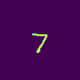
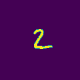
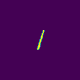
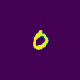
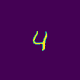
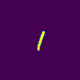
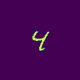
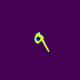

In [36]:
with torch.no_grad():
    batch = next(test_gen)
    inp, out_gt = batch["inp"], batch["out"]
    out_pred = nca(inp.to(device), steps=500)
    nca_out_to_vids(out_pred, columns=8)

In [ ]:
# nca_loaded = load_latest_model(".checkpoints/")